In [17]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# Mount Drive
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

drive.mount('/content/drive')

# Setup directories
SOURCE_DIR = "/content/drive/MyDrive/archive (7)"  # Make sure this path is correct
DEST_DIR = "/content/dataset"

# Copy dataset to local Colab if not already done
if not os.path.exists(DEST_DIR):
    shutil.copytree(SOURCE_DIR, DEST_DIR)
    print("✅ Dataset copied to Colab local storage.")
else:
    print("📁 Dataset already exists in Colab.")

# Define paths
TRAIN_DIR = os.path.join(DEST_DIR, "train")
TEST_DIR = os.path.join(DEST_DIR, "test")

# Image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Image augmentation with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15  # Important
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training and validation generators from the same train directory
# ✅ Define a validation set from TRAIN_DIR using 15% split (already done)
# NO changes needed in augmentation section

# ✅ Change: Set a seed to ensure consistent split
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    seed=42  # Ensures same split every run
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    seed=42  # Consistent validation set
)


# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("Class Mapping:", train_generator.class_indices)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Dataset already exists in Colab.
Found 10098 images belonging to 2 classes.
Found 1781 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


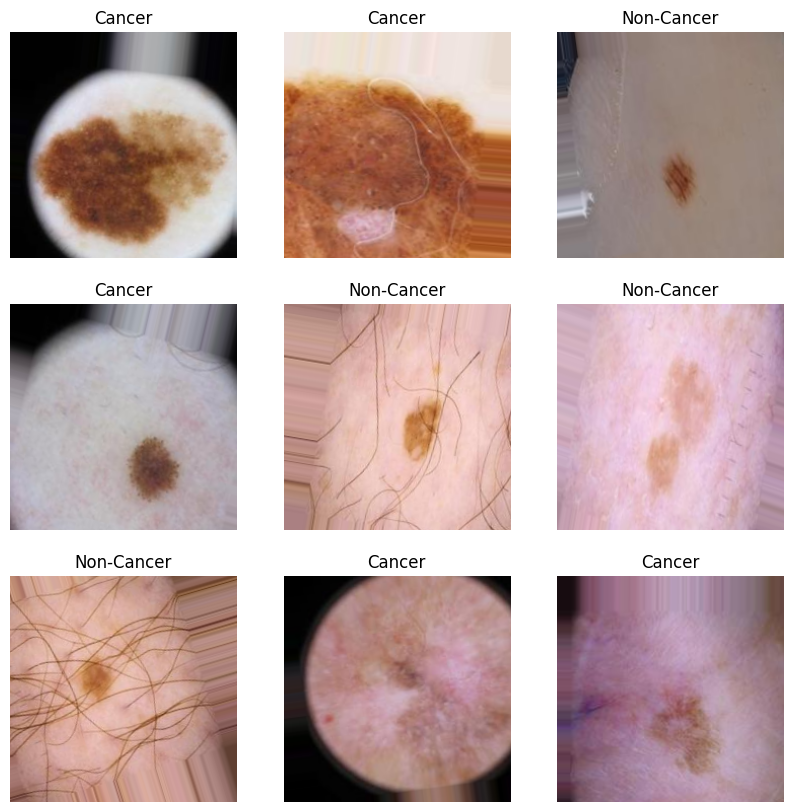

In [19]:
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non-Cancer")
        plt.axis("off")
    plt.show()

plot_images(train_generator)


In [20]:
import os

def count_images_in_each_class(folder_path):
    for class_dir in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_dir)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            print(f"{class_dir}: {count} images")

print("Training Set:")
count_images_in_each_class(TRAIN_DIR)

print("\nTesting Set:")
count_images_in_each_class(TEST_DIR)


Training Set:
Benign: 6289 images
Malignant: 5590 images

Testing Set:
Benign: 1000 images
Malignant: 1000 images


In [21]:
print("Class Mapping:", train_generator.class_indices)


Class Mapping: {'Benign': 0, 'Malignant': 1}


In [22]:
# Build EfficientNetB0 Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # ✅ Phase 1: freeze base

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# ✅ Phase 1: Compile & Train with frozen base
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print("🚀 Phase 1: Training top layers only")
model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stop, reduce_lr])

# ✅ Phase 2: Unfreeze and Fine-tune entire EfficientNet
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print("🔧 Phase 2: Fine-tuning full EfficientNet")
model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stop, reduce_lr])

# ✅ Final evaluation on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


🚀 Phase 1: Training top layers only


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 174s 487ms/step - accuracy: 0.4998 - loss: 0.7020 - val_accuracy: 0.5295 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 2/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 137s 435ms/step - accuracy: 0.5140 - loss: 0.6977 - val_accuracy: 0.5295 - val_loss: 0.6918 - learning_rate: 1.0000e-04
Epoch 3/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.5107 - loss: 0.6976 - val_accuracy: 0.5295 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 4/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 137s 433ms/step - accuracy: 0.5166 - loss: 0.6965 - val_accuracy: 0.5295 - val_loss: 0.6920 - learning_rate: 1.0000e-04
Epoch 5/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 139s 440ms/step - accuracy: 0.5107 - loss: 0.6989 - val_accuracy: 0.5295 - val_loss: 0.6925 - learning_rate: 1.0000e-04
🔧 Phase 2: Fine-tuning full EfficientNet
Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 263s 602ms/step - accuracy: 0.6653 - loss: 0.6022 - val_accuracy: 0.3273 - val_loss: 0.7151 - learning_rate: 1.0000e-05
Epoc

In [25]:
model.save("/content/efficientnet_breast_cancer.h5")
print("✅ Model saved successfully as HDF5 (.h5)")


✅ Model saved successfully as HDF5 (.h5)


In [ ]:
# ✅ Save the model
model.save("efficient_breast_cancer.keras")
print("✅ Model saved as skin_cancer_cnn.keras")

In [36]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.8640 - loss: 0.3114
✅ Final Test Accuracy: 0.8745


In [33]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


model = load_model('efficient_breast_cancer.keras')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"


    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 215 variables whereas the saved optimizer has 428 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


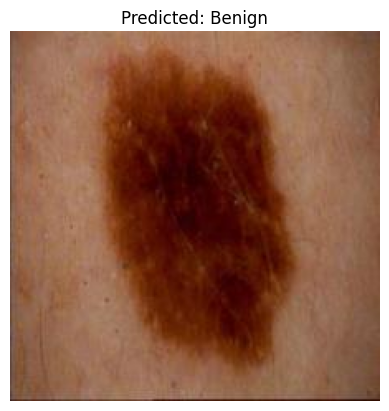

In [34]:


predict_skin_cancer("/content/dataset/test/Benign/6299.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


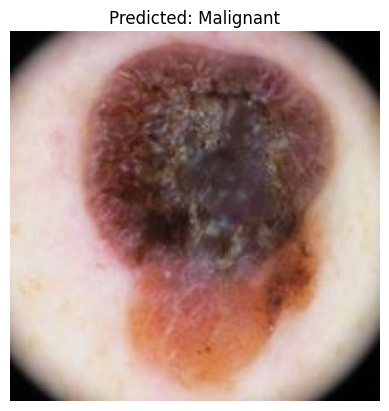

In [35]:


predict_skin_cancer("/content/dataset/test/Malignant/5603.jpg", model)

In [ ]:
# Copy the model file to your Google Drive
!cp /content/skin_cancer_cnn.keras /content/drive/MyDrive/skin_cancer_cnn.keras
